In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os.path

#======================================================================
# directory of data set:
DATA_DIR = './data/'

# data sets:
DATA = {
    
    # Excel datasets:
    'active_cases' : 'TexasCOVID-19ActiveCaseDatabyCounty.xlsx',
    'case_counts' : 'TexasCOVID-19CaseCountDatabyCounty.xlsx',
    'fatality_counts' : 'TexasCOVID-19FatalityCountDatabyCounty.xlsx',
    'legacy_active_cases' : 'TexasCOVID-19LegacyActiveCaseDatabyCounty.xlsx',
    'new_confirmed_cases' : 'TexasCOVID-19NewConfirmedCasesbyCounty.xlsx',
    'new_probable_cases' : 'TexasCOVID-19NewProbableCasesbyCounty.xlsx',
    'probable_cases' : 'TexasCOVID-19ProbableCasesbyCounty.xlsx',
    
    # CSV datasets:
    'total_population' : '2019_txpopest_county.csv'
}

# default county in TX:
DEFAULT_COUNTY = 'McLennan'

# date of first data point (hardcoded by dataset):
DATA_START_DATES = {
    'active_cases' :        np.datetime64('2020-12-11'),
    'case_counts' :         np.datetime64('2020-03-04'),
    'fatality_counts':      None, # not used here
    'legacy_active_cases' : np.datetime64('2020-04-07'),
    'new_confirmed_cases' : None, # not used here
    'new_probable_cases' :  None, # not used here
    'probable_cases' :      np.datetime64('2020-11-01'),
}

#=======================================================================

def load_active_cases(county=DEFAULT_COUNTY):
    # import couty of interest data
    new_coi_data = pd.read_excel(DATA_DIR + DATA['active_cases'], index_col=None, header=2) \
        .query(f'County == \'{county}\'')

    # import county of interest legacy data:
    leg_coi_data = pd.read_excel(DATA_DIR + DATA['legacy_active_cases'], index_col=None, header=2) \
        .query(f'County == \'{county}\'')

    # trim datasets:
    new_coi_y = new_coi_data.to_numpy()[0,2:]
    leg_coi_y = leg_coi_data.to_numpy()[0,2:]
    coi_y = np.concatenate((leg_coi_y, new_coi_y))

    # initialize date ranges:
    start_t = DATA_START_DATES['legacy_active_cases']
    end_t = start_t + np.timedelta64(len(coi_y), 'D')
    coi_t = np.arange(start_t, end_t, dtype='datetime64[D]')

    # return (dates, # of active cases)
    return (coi_t, coi_y)

def load_case_counts(county=DEFAULT_COUNTY):
    # import county of interest data:
    coi_data = pd.read_excel(DATA_DIR + DATA['case_counts'], index_col=None, header=2) \
        .query(f'`County Name` == \'{county}\'')
    coi_y = coi_data.to_numpy()[0,1:]
    
    # initialize data ranges:
    start_t = DATA_START_DATES['case_counts']
    end_t = start_t + np.timedelta64(len(coi_y), 'D')
    coi_t = np.arange(start_t, end_t, dtype='datetime64[D]')

    # return (dates, case counts)
    return (coi_t, coi_y)

def load_probable_cases(county=DEFAULT_COUNTY):
    # import county of interest data:
    coi_data = pd.read_excel(DATA_DIR + DATA['probable_cases'], 
                             index_col=None, header=2) \
        .query(f'`County` == \'{county}\'')
    coi_y = coi_data.to_numpy()[0,1:]
    
    # initialize data ranges:
    start_t = DATA_START_DATES['probable_cases']
    end_t = start_t + np.timedelta64(len(coi_y), 'D')
    coi_t = np.arange(start_t, end_t, dtype='datetime64[D]')
    
    # return (dates, probable cases)
    return (coi_t, coi_y)

def load_population(county=DEFAULT_COUNTY):
    # import county population data:
    pop_data = pd.read_csv(DATA_DIR + DATA['total_population']) \
        .query(f'`county` == \'{county}\'')
    
    # extract Jan 1 2020 population estimate
    return pop_data.jan1_2020_pop_est.to_numpy()[0]

def load_county_list():
    df = pd.read_csv(DATA_DIR + DATA['total_population'])
    return df['county'].tolist()
    

/shared/colin/git/tx_covid_models/env/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# of days tracked:  392
Estimated total population:  255372


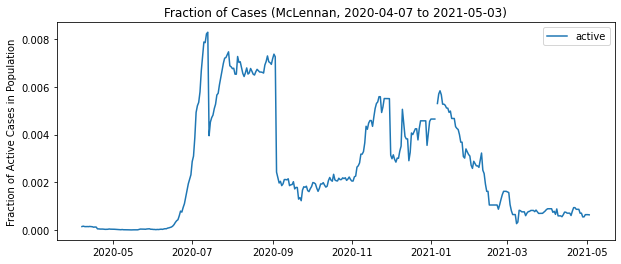

In [2]:
# load active + probable cases:
coi_t, coi_y = load_active_cases()
coi_pt, coi_py = load_probable_cases()

# normalize by population (Jan 1 2020)
pop_estimate = load_population()
coi_y_norm = coi_y / pop_estimate

# indicate $ of data points, population:
print('# of days tracked: ', len(coi_t))
print('Estimated total population: ', pop_estimate)

# plot active cases (proportion of population):
plt.figure(figsize=(10,4))
plt.ylabel('Fraction of Active Cases in Population')
plt.title(f'Fraction of Cases ({DEFAULT_COUNTY}, {coi_t[0]} to {coi_t[-1]})')
plt.plot(coi_t, coi_y_norm, label='active')
plt.legend()
plt.show()

In [3]:
#======================================================================

# counties to train on (exclude corrupted county datasets):
COUNTY_DATASETS = list(set(load_county_list()) - set([
    'De Witt',
    'State of Texas'
]))

SEQUENCE_LENGTH = 11

# file containing sequence data (delete to regenerate)
FILE_OUT = 'rnn_seq_data.npy'

#======================================================================

def prepare_data(t_list, s_y_list, i_y_list, seq_len=32):
    sequences = []
    for t, s_y, i_y in zip(t_list, s_y_list, i_y_list):
        assert(len(t) == len(s_y))
        assert(len(t) == len(i_y))
        data = list(zip(s_y,i_y))
        for i in range(len(t)//seq_len):
            sequences.append(data[i*seq_len:(i+1)*seq_len])
    
    return np.array(sequences)

# attempt to load from cached file:
sequences = None
if not os.path.isfile(f'./{FILE_OUT}'):
    t_list = []
    s_y_list = []
    i_y_list = []
    
    for county in COUNTY_DATASETS:
        print(county)
        # generate SIR model estimate quantities:
        coi_active_t, coi_active_y = load_active_cases(county)
        coi_total_t, coi_total_y = load_case_counts(county)
        pop_estimate = load_population(county)

        S_t, S_y = coi_total_t, 1. - (coi_total_y/pop_estimate)
        I_t, I_y = coi_active_t, (coi_active_y / pop_estimate)
        dS_y = [0.0]
        dS_y.extend(np.diff(S_y))
        dS_y = np.array(dS_y)
        assert(len(dS_y) == len(S_t))

        # take the intersection of supported time intervals:
        start_t = max(S_t[0], I_t[0])
        end_t = min(S_t[-1], I_t[-1])
        S_y = S_y[(start_t < S_t) & (S_t < end_t)]
        dS_y = dS_y[(start_t < S_t) & (S_t < end_t)]
        S_t = S_t[(start_t < S_t) & (S_t < end_t)]
        I_y = I_y[(start_t < I_t) & (I_t < end_t)]
        I_t = I_t[(start_t < I_t) & (I_t < end_t)]

        t_list.append(S_t)
        s_y_list.append(dS_y)
        i_y_list.append(I_y)

    sequences = prepare_data(t_list, s_y_list, i_y_list, seq_len=SEQUENCE_LENGTH)

    with open(FILE_OUT,'wb') as f:
        np.save(f,sequences)
else:
    with open(FILE_OUT, 'rb') as f:
        sequences = np.load(f,allow_pickle=True)
    print(f'File "{FILE_OUT}" loaded.')
    
assert(len(sequences) > 0)
print(f'# of sequences: {len(sequences)}')
print(f'sequence length: {len(sequences[0])}')

File "rnn_seq_data.npy" loaded.
# of sequences: 7337
sequence length: 11


In [4]:
# import keras layers API:
try:
    import tensorflow.keras as keras
except:
    import keras

# other dependencies:
import random

# default values (Set below)
NOISE_DELTA = 0.
NOISE_EPSILON = 0.

def construct_rnn(seq_len=10, input_features=2, output_features=2, 
                  hidden_nodes=4, lstm_units=64):
    
    # construct time distributed layer:
    td_layers = keras.Sequential()
    td_layers.add(keras.layers.Input(shape=(input_features,)))

    if hidden_nodes is not None:
        td_layers.add(keras.layers.Dense(units=hidden_nodes, activation=keras.activations.tanh))

    # add recurrent layer:
    network = keras.Sequential()
    network.add(keras.layers.TimeDistributed(td_layers, input_shape=(seq_len,input_features)))
    network.add(keras.layers.LSTM(
        units=lstm_units,
        return_sequences=False,
        kernel_initializer=keras.initializers.RandomNormal(stddev=0.01)
    ))

    # add final decision layer:    
    network.add(keras.layers.Flatten())
    network.add(keras.layers.Dense(units=output_features, activation=keras.activations.tanh))
    
    # compile network with MSE (since we are modeling a dynamical system):
    network.compile(optimizer=keras.optimizers.RMSprop(), loss='mean_squared_error', metrics=['mse'])
    network.build(input_shape=(seq_len,input_features))

    return network

def train_rnn(network, train_data, targets, epochs, early_stopping_patience=0, verbose=True):
    callbacks = []
    if early_stopping_patience > 0:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='loss', patience=early_stopping_patience))

    return network.fit(train_data, targets, epochs=epochs, 
                       verbose=verbose, callbacks=callbacks)

def save_rnn(network, rnn_file):
    network.save(f'{rnn_file}.h5')

def load_rnn(network_name):
    return keras.models.load_model()

def forecast(network, d_seq, d_0, n_steps=30, verbose=False):
    
    forecast = [d_0]
    forecasted_seq = list(d_seq.copy())
    if verbose:
        print(f'[-1]: {forecasted_seq[-1]}')
    for n in range(n_steps):
        input_seq = np.array([forecasted_seq])
        d_est = network.predict(input_seq)[0]
        
        # require that dS/dt <= 0, I >= 0;
        # approximating a Wiener process:
        if d_est[0] > NOISE_DELTA:
            d_est[0] = np.random.uniform(-NOISE_EPSILON,0.0)
        if d_est[1] < NOISE_DELTA:
            d_est[1] = np.random.uniform(0.0, NOISE_EPSILON)
        
        est = np.array([forecast[-1][0] + d_est[0], d_est[1]])
        forecast.append(est)
        forecasted_seq = forecasted_seq[1:]
        forecasted_seq.append(d_est)
        
        if verbose:
            print(f'[{n}]: {d_est}')
    
    return np.array(forecast)

def construct_rnn_data(sequences, seq_len, holdout=0.2, shuffle=True):
    seq = sequences.copy()
    assert(seq_len < len(seq[0]))
    
    if shuffle:
        random.shuffle(seq)
    
    val_seqs = []
    val_seqs_y = []
    train_seqs = []
    train_seqs_y = []
    
    for s in seq[:int(holdout*len(sequences))]:
        val_seqs.append(s[:seq_len])
        val_seqs_y.append(s[seq_len])
        
    for s in seq[int(holdout*len(sequences)):]:
        train_seqs.append(s[:seq_len])
        train_seqs_y.append(s[seq_len])
        
    return np.array(train_seqs), np.array(train_seqs_y), \
           np.array(val_seqs), np.array(val_seqs_y)


In [5]:
#=======================================================
LSTM_UNITS = 32
RNN_SEQ_LENGTH = 10
HIDDEN_NODES = 4

# noise parameters:
NOISE_DELTA = 1e-4
NOISE_EPSILON = 1e-3

# extra holdout (e.g. for hyperparemeter validation)
VALIDATION_HOLDOUT = 0.05

assert(RNN_SEQ_LENGTH < len(sequences[0]))
#=======================================================

rnn = construct_rnn(RNN_SEQ_LENGTH, lstm_units=LSTM_UNITS, hidden_nodes=HIDDEN_NODES)
rnn.summary(print_fn=print)

train_x, train_y, val_x, val_y = construct_rnn_data(sequences, RNN_SEQ_LENGTH,
                                                    holdout=VALIDATION_HOLDOUT)
loss_data = []
print('\nTraining/Validation Split:\n---------------------------')
print(f'RNN input length: {len(train_x[0])}')
print(f'# training sequences: {len(train_x)}')
print(f'# validation sequences: {len(val_x)}')

#print(list(zip(train_x,train_y))[:10])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 4)             12        
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 4,814
Trainable params: 4,814
Non-trainable params: 0
_________________________________________________________________

Training/Validation Split:
---------------------------
RNN input length: 10
# training sequences: 6971
# validation sequences: 366


In [6]:
#=======================================================
# This is the number of times the RNN sees the whole
# dataset:
N_EPOCHS = 130
#=======================================================

# Train RNN:
history = train_rnn(rnn, train_x, train_y, N_EPOCHS, verbose=True)
loss_data.extend(history.history['loss'])


Epoch 1/130
218/218 [==============================] - 2s 3ms/step - loss: 1.8403e-05 - mse: 1.8403e-05
Epoch 2/130
218/218 [==============================] - 1s 3ms/step - loss: 5.6847e-06 - mse: 5.6847e-06
Epoch 3/130
218/218 [==============================] - 1s 3ms/step - loss: 3.4699e-06 - mse: 3.4699e-06
Epoch 4/130
218/218 [==============================] - 1s 3ms/step - loss: 3.0694e-06 - mse: 3.0694e-06
Epoch 5/130
218/218 [==============================] - 1s 3ms/step - loss: 2.6460e-06 - mse: 2.6460e-06
Epoch 6/130
218/218 [==============================] - 1s 3ms/step - loss: 2.7106e-06 - mse: 2.7106e-06
Epoch 7/130
218/218 [==============================] - 1s 3ms/step - loss: 2.1897e-06 - mse: 2.1897e-06
Epoch 8/130
218/218 [==============================] - 1s 3ms/step - loss: 1.9238e-06 - mse: 1.9238e-06
Epoch 9/130
218/218 [==============================] - 1s 3ms/step - loss: 2.1237e-06 - mse: 2.1237e-06
Epoch 10/130
218/218 [==============================] - 1s 3ms/s

218/218 [==============================] - 1s 3ms/step - loss: 1.5950e-06 - mse: 1.5950e-06
Epoch 80/130
218/218 [==============================] - 1s 3ms/step - loss: 1.3727e-06 - mse: 1.3727e-06
Epoch 81/130
218/218 [==============================] - 1s 4ms/step - loss: 1.9114e-06 - mse: 1.9114e-06
Epoch 82/130
218/218 [==============================] - 1s 4ms/step - loss: 2.1050e-06 - mse: 2.1050e-06
Epoch 83/130
218/218 [==============================] - 1s 4ms/step - loss: 1.8664e-06 - mse: 1.8664e-06
Epoch 84/130
218/218 [==============================] - 1s 3ms/step - loss: 1.9303e-06 - mse: 1.9303e-06
Epoch 85/130
218/218 [==============================] - 1s 3ms/step - loss: 1.3231e-06 - mse: 1.3231e-06
Epoch 86/130
218/218 [==============================] - 1s 4ms/step - loss: 1.4075e-06 - mse: 1.4075e-06
Epoch 87/130
218/218 [==============================] - 1s 4ms/step - loss: 1.7980e-06 - mse: 1.7980e-06
Epoch 88/130
218/218 [==============================] - 1s 4ms/step 

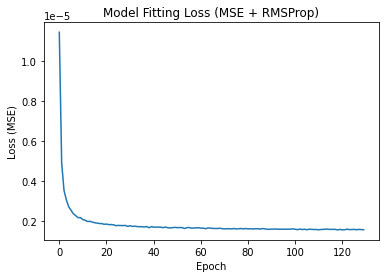

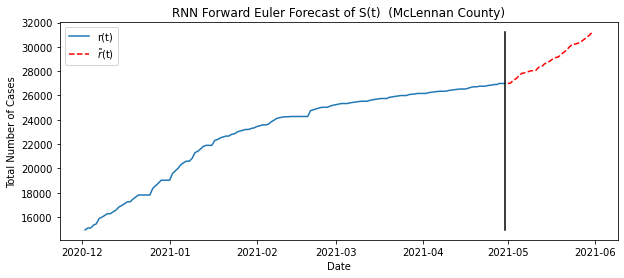

In [7]:
#=======================================================

FORECAST_COUNTY = 'McLennan'

#=======================================================


# generate SIR model estimate quantities:
def forecast_county(network, county, n_days=30):
    coi_active_t, coi_active_y = load_active_cases(county)
    coi_total_t, coi_total_y = load_case_counts(county)
    pop_estimate = load_population(county)

    S_t, S_y = coi_total_t, 1. - (coi_total_y/pop_estimate)
    I_t, I_y = coi_active_t, (coi_active_y / pop_estimate)
    dS_y = [0.0]
    dS_y.extend(np.diff(S_y))
    dS_y = np.array(dS_y)
    
    # take the intersection of supported time intervals:
    start_t = max(S_t[0], I_t[0])
    end_t = min(S_t[-1], I_t[-1])
    S_y = S_y[(start_t < S_t) & (S_t < end_t)]
    dS_y = dS_y[(start_t < S_t) & (S_t < end_t)]
    S_t = S_t[(start_t < S_t) & (S_t < end_t)]
    I_y = I_y[(start_t < I_t) & (I_t < end_t)]
    I_t = I_t[(start_t < I_t) & (I_t < end_t)]
    
    d_coi_seq = np.array(list(zip(dS_y,I_y)))
    coi_seq = np.array(list(zip(S_y,I_y)))
    assert(len(d_coi_seq) > RNN_SEQ_LENGTH)
    d_coi_seq_end = d_coi_seq[len(d_coi_seq)-RNN_SEQ_LENGTH:]
    coi_seq_end = coi_seq[len(coi_seq)-RNN_SEQ_LENGTH:]
    d_0 = coi_seq_end[-1]
    
    # generate original data:
    coi_t = S_t
    coi_total_y = pop_estimate*(1.-coi_seq[:,0])
    coi_active_y = pop_estimate*coi_seq[:,1]
    
    # generate forecast data via RNN:
    coi_seq_est = forecast(network, d_coi_seq_end, d_0, n_steps=n_days, verbose=False)
    est_t = np.array([
        end_t + np.timedelta64(i, 'D')
        for i in range(len(coi_seq_est))
    ])
    est_total_y = pop_estimate*(1.-coi_seq_est[:,0])
    est_active_y = pop_estimate*coi_seq_est[:,1]
    
    return (coi_t, coi_total_y, coi_active_y), \
           (est_t, est_total_y, est_active_y)

# plot fitting loss function:
plt.figure()
plt.title('Model Fitting Loss (MSE + RMSProp)')
plt.plot(loss_data)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.show()

# load active and total case data:
coi_active_t, coi_active_y = load_active_cases(FORECAST_COUNTY)
coi_total_t, coi_total_y = load_case_counts(FORECAST_COUNTY)

# predict total number of cases:
data, forecast_data = forecast_county(rnn, FORECAST_COUNTY)

# plot forecasted total number of cases:
plt.figure(figsize=(10,4))
plt.title(f'RNN Forward Euler Forecast of S(t)  ({FORECAST_COUNTY} County)')
data_vis_x = data[0][-150:]
data_vis_y = data[1][-150:]
plt.plot(data_vis_x, data_vis_y, label=r'r(t)')
plt.xlabel('Date')
plt.ylabel('Total Number of Cases')
plt.plot(forecast_data[0],forecast_data[1], 'r--', label=r'$\tilde{r}$(t)')
plt.plot([data[0][-1]]*2,[min(np.min(data_vis_y),np.min(forecast_data[1])),
                      max(np.max(data_vis_y),np.max(forecast_data[1]))],'k')
plt.legend()
plt.show()

